In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Memory

In [2]:
from azure_table_interface import *

In [3]:
memory = Memory('./_cache_')

In [59]:
ID_to_name = {'nesta-1': 'Priory Rd (South)',
              'nesta-2': 'Priory Rd (North)',
              'nesta-2-1': 'Priory Rd (North)',
              'nesta-4': 'Horseshoe Bridge',
              'nesta-5': 'Kent Rd',
              'nesta-6': 'Portswood Rd',
              'nesta-7': 'St Denys Rd',
              'nesta-8': 'Priory Rd-Kent Rd junction'}

In [4]:
@memory.cache
def get_sensor_data(sensor_id, **kwargs):
    res = query_aq_data(sensor_id,
                        **kwargs)
    
    res = res.resample('15min').mean()
    
    if len(res.columns) == 1:
        res.columns = [sensor_id.split("_")[1]]
    
    return res

In [64]:
def get_all_sensor_data(col='pm25'):
    sensor_ids = ['aq-deployment_nesta-' + s for s in ['1', '2', '2-1', '4', '5', '6', '7', '8']]
    
    dfs = [get_sensor_data(sensor_id, from_date='2019-01-01', cols=[col]) for sensor_id in sensor_ids]
    
    data = pd.concat(dfs, axis=1)
    
    # Deal with nesta-2 and nesta-2-1 sensors which are in the same location, but -2-1 was a replacement
    # after -2 failed. Just combine the two columns as one
    data['nesta-2'] = data['nesta-2'].combine_first(data['nesta-2-1'])
    del data['nesta-2-1']
    
    hourly_mean = data.resample('1H').mean()
    daily_mean = data.resample('1D').mean()
    
    return data, hourly_mean, daily_mean

In [65]:
data, hourly_mean, daily_mean = get_all_sensor_data()

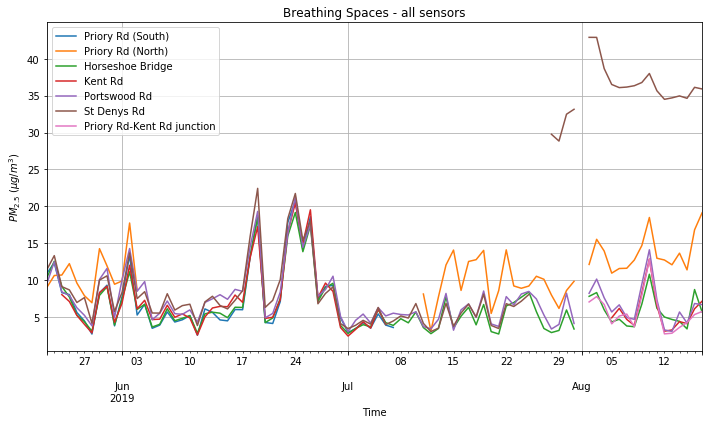

In [70]:
daily_mean.rename(columns=ID_to_name).plot(figsize=(10,6))
plt.grid(which='major')
plt.title('Breathing Spaces - all sensors')
plt.xlabel('Time')
plt.ylabel('$PM_{2.5}$ ($\mu g / m^3$)')
plt.tight_layout()
plt.savefig('graphs/AllSensors.png', dpi=200)

In [79]:
daily_mean_no_nesta8 = daily_mean.copy()
del daily_mean_no_nesta8['nesta-8']
del daily_mean_no_nesta8['nesta-1']
daily_mean_no_nesta8['2019-08']
len(daily_mean_no_nesta8.dropna())

24

In [74]:
daily_mean_no_na

,nesta-1,nesta-2,nesta-4,nesta-5,nesta-6,nesta-7
timestamp,,,,,,
2019-05-24,8.317647,10.696203,9.146341,8.044118,8.426966,9.125000
2019-05-25,8.050000,12.240000,7.724138,7.114943,7.931818,8.683544
2019-05-26,5.626506,9.611111,5.265060,5.229167,6.267442,6.976471
2019-05-27,4.481928,7.900000,4.382716,4.022222,5.240964,7.639535
2019-05-28,2.703704,6.944444,3.086420,2.858696,3.817073,4.164706
2019-05-29,8.269231,14.268657,7.934211,8.317647,10.097561,10.012346
2019-05-30,9.320513,11.938272,9.111111,9.188235,11.593023,10.590909
2019-05-31,3.813333,9.450704,3.930233,4.296703,4.966667,5.773810
2019-06-01,7.756098,9.895522,7.433735,6.898876,10.058824,8.361446


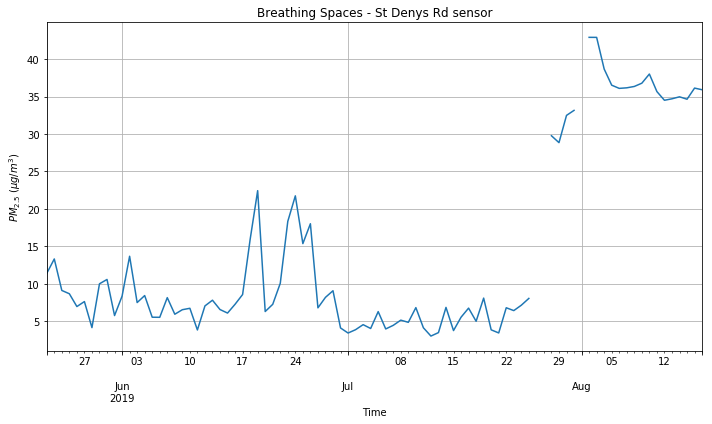

In [75]:
data['nesta-7'].resample('1D').mean().plot(figsize=(10,6))
plt.grid(which='major')
plt.title('Breathing Spaces - St Denys Rd sensor')
plt.xlabel('Time')
plt.ylabel('$PM_{2.5}$ ($\mu g / m^3$)')
plt.tight_layout()
plt.savefig('graphs/St Denys Rd sensor.png', dpi=200)

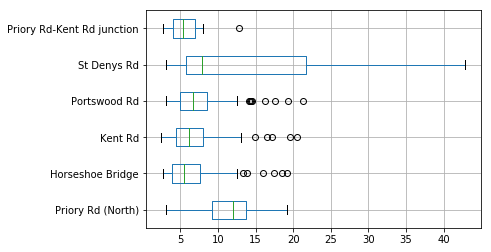

In [38]:
daily_mean.rename(columns=ID_to_name).boxplot(vert=False)

In [80]:
import missingno as msno

In [92]:
dm2 = daily_mean.set_index(daily_mean.index.to_period())

In [95]:
dm2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 88 entries, 2019-05-22 to 2019-08-17
Freq: D
Data columns (total 7 columns):
nesta-1    47 non-null float64
nesta-2    50 non-null float64
nesta-4    87 non-null float64
nesta-5    57 non-null float64
nesta-6    87 non-null float64
nesta-7    85 non-null float64
nesta-8    16 non-null float64
dtypes: float64(7)
memory usage: 5.5 KB


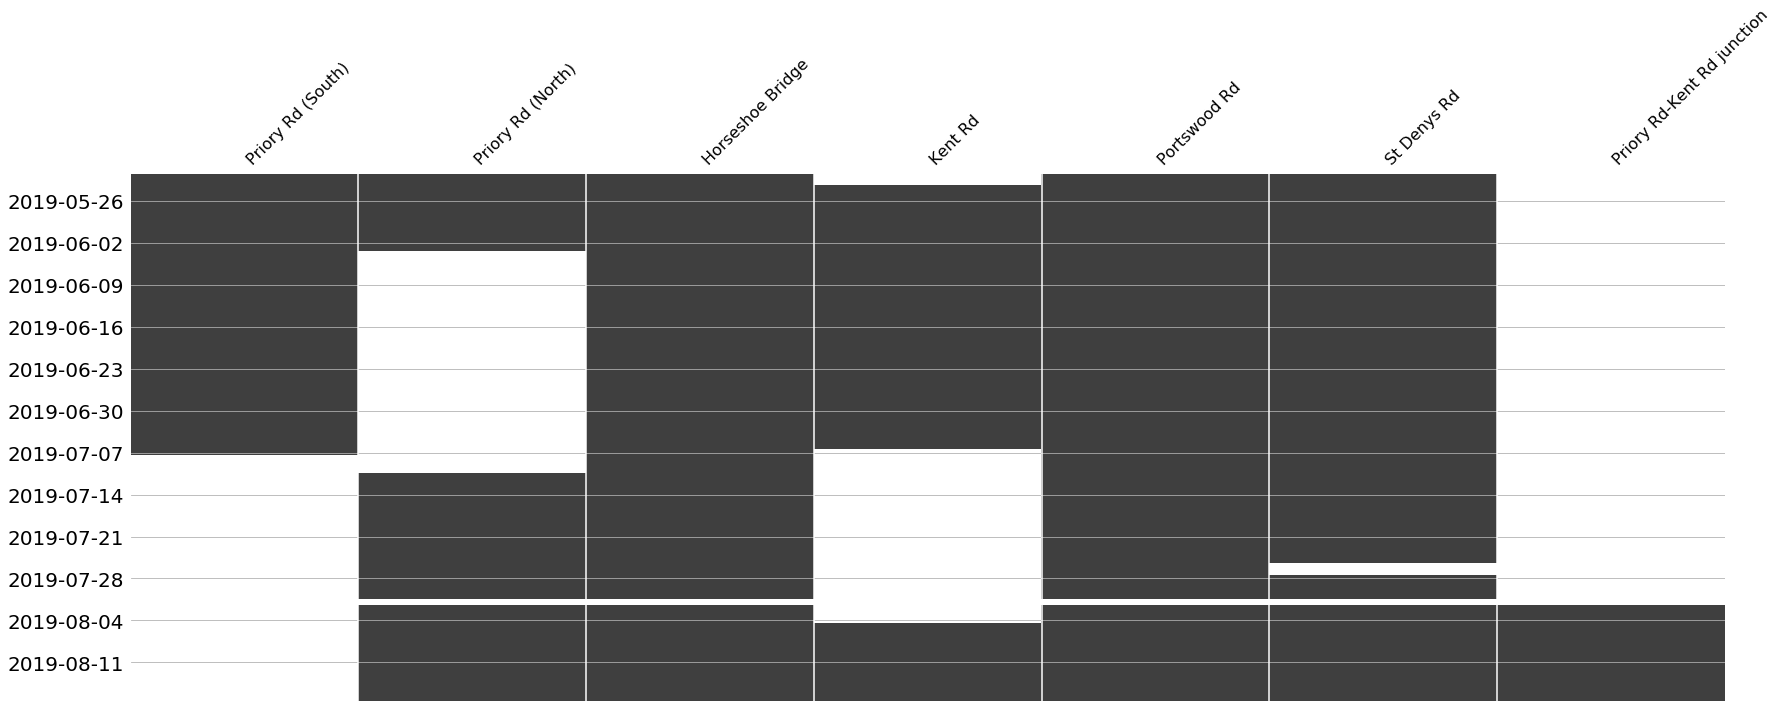

In [113]:
msno.matrix(dm2.rename(columns=ID_to_name), freq='W', sparkline=False)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('graphs/DataAvailability.png', dpi=200)